In [247]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import linear_model
import numpy as np
from numpy import linalg as LA
from scipy.stats import multivariate_normal

Чтение и предобработка данных

In [4]:
data = pd.read_csv('/content/owid-covid-data.csv')

In [ ]:
data

In [5]:
russia_data = data[data['iso_code']=='RUS'][data['date'] >= '2020-03-03']
russia_data.index = [x for x in range(1, len(russia_data)+1)]
russia_data.loc[ russia_data['new_cases'] == 0, 'new_cases'] = 1 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [6]:
rus_train_data = russia_data[:50]
rus_test_data = russia_data[50:]

Графики данных

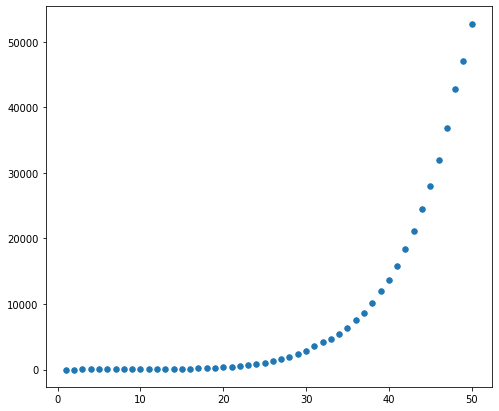

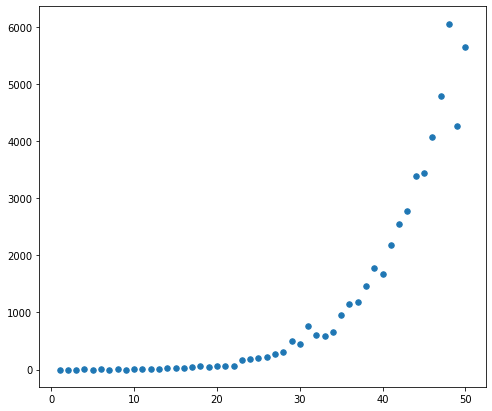

In [7]:
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111)
ax.scatter(rus_train_data.index,rus_train_data['total_cases'], marker='.', s=120)
plt.show()
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111)
ax.scatter(rus_train_data.index,rus_train_data['new_cases'], marker='.', s=120)
plt.show()

Обучение моделей

In [248]:
days = np.array(rus_train_data.index).reshape(len(rus_train_data.index),1)
totals = [[math.log(y)] for y in rus_train_data['total_cases']]
totals_model = linear_model.LinearRegression().fit(days, totals)
totals_predict = totals_model.predict(days)

In [232]:
new = [[math.log(y)] for y in rus_train_data['new_cases']]
new_model = linear_model.LinearRegression().fit(days, new)
new_predict = new_model.predict(days)

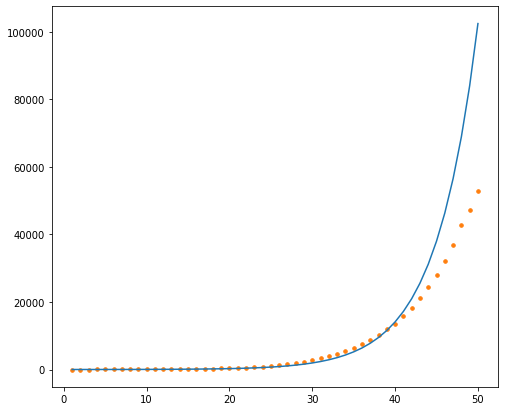

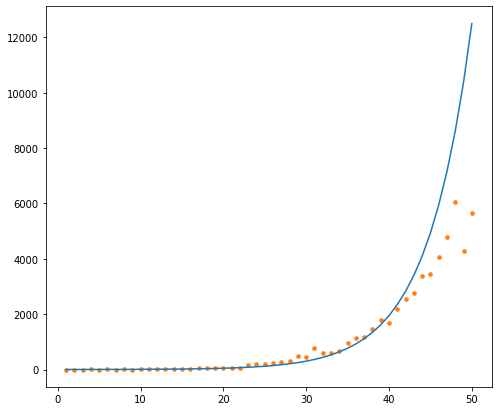

In [233]:
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111)
ax.scatter(rus_train_data.index,rus_train_data['total_cases'], marker='.', s=50, c='#ff7f0e')
ax.plot(rus_train_data.index, [math.exp(y)for y in totals_predict])
plt.show()

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111)
ax.scatter(rus_train_data.index, rus_train_data['new_cases'], marker='.', s=50, c='#ff7f0e')
ax.plot(rus_train_data.index, [math.exp(y)for y in new_predict])
plt.show()

Апостреорное распределение

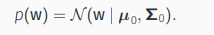
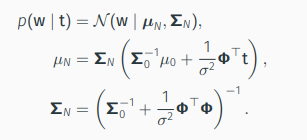



In [390]:
a=1000
u0, z0 = np.array([0, 0]),  np.array([[a, 0], [0, a]])
sigm = sum((totals - totals_predict)**2)/len(totals)
sigm

array([0.12183046])

In [391]:
Fi = np.vstack((np.ones(50),np.array(days.reshape(len(days))).ravel())).T

In [392]:
zn = LA.inv((LA.inv(z0) + 1/(sigm * sigm) * (Fi.T).dot(Fi)))
zn

array([[ 1.22376078e-03, -3.63493302e-05],
       [-3.63493302e-05,  1.42546435e-06]])

In [393]:
un = zn.dot(LA.inv(z0).dot(u0) + 1/(sigm * sigm) * (Fi.T).dot(np.array(totals)).reshape(2))
un

array([1.62244426, 0.19829097])

In [442]:
print("for totals_cases N (") 
print(un)
print(zn)
print(')')

for totals_cases N (
[1.62244426 0.19829097]
[[ 1.22376078e-03 -3.63493302e-05]
 [-3.63493302e-05  1.42546435e-06]]
)


3.

In [397]:
samples = np.random.multivariate_normal(un,zn,100)


In [419]:
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i] = w[0] + w[1]*xs
    return res

In [ ]:
x = sample_statistics(un ,zn , days.reshape(len(days)), n=1000)


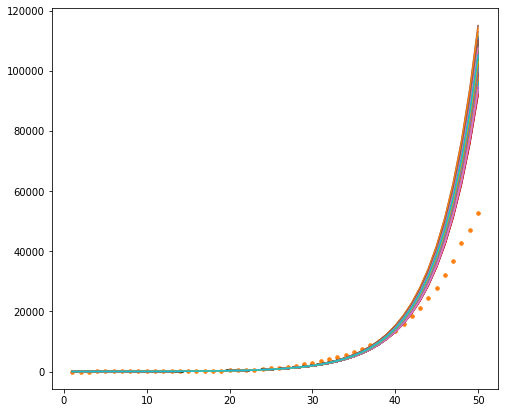

In [441]:
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111)
ax.scatter(rus_train_data.index, rus_train_data['total_cases'], marker='.', s=50, c='#ff7f0e')
for i in x :
  ax.plot(rus_train_data.index, [math.exp(y)for y in i])
plt.show()